# 与学习相关的技巧

## 参数的更新

神经网络的学习的目的是找到使损失函数的值尽可能小的参数，寻找最优参数的过程称为**最优化**；

最优化方法：

* 随机梯度下降（SGD）：
    
    $$
    W \leftarrow W - \eta \frac{\partial L}{\partial W}
    $$
    
    其中$\eta$为学习率，$L$为损失函数

In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

SGD的缺点：

如果函数的形状非均向，比如延伸状，则搜索会非常低效。

* Momentum

$$
\mathbf{v} \leftarrow \alpha \mathbf{v} - \eta \frac{\partial{L}}{\partial \mathbf{W}}
$$

$$
\mathbf{W} \leftarrow \mathbf{W} + \mathbf{v}
$$

In [2]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def updata(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

* AdaGrad

$$
\mathbf{h} \leftarrow \mathbf{h} + \frac{\partial L}{\partial{\mathbf{W}}} \odot \frac{\partial L}{\partial{\mathbf{W}}}
$$
$$
\mathbf{W} \leftarrow - \eta \frac{1}{\sqrt{\mathbf{h}}} \frac{\partial L}{\partial{\mathbf{W}}}
$$

In [3]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            for key in params.keys():
                self.h[key] += grads[key] * grads[key]
                params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

* Adam

    Adam融合了Momentum和AdaGrad的特点。

## 权重的初始值


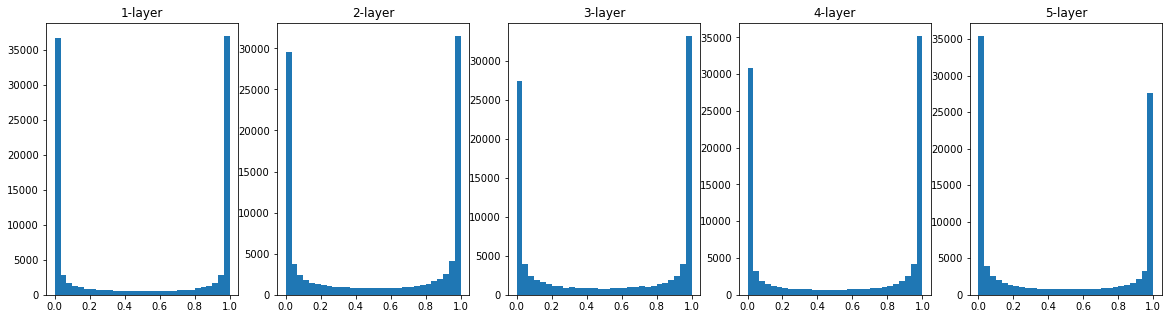

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100
hiden_layer_size = 5
activations = {}

for i in range(hiden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) * 1

    z = np.dot(x, w)
    a = sigmoid(z)
    activations[i] = a
plt.figure(figsize=(20,5))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i + 1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

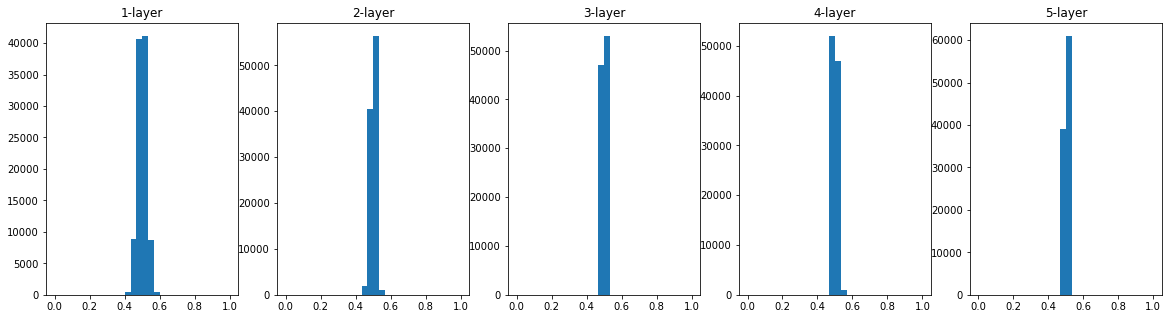

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100
hiden_layer_size = 5
activations = {}

for i in range(hiden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) * 0.01

    z = np.dot(x, w)
    a = sigmoid(z)
    activations[i] = a
plt.figure(figsize=(20,5))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i + 1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

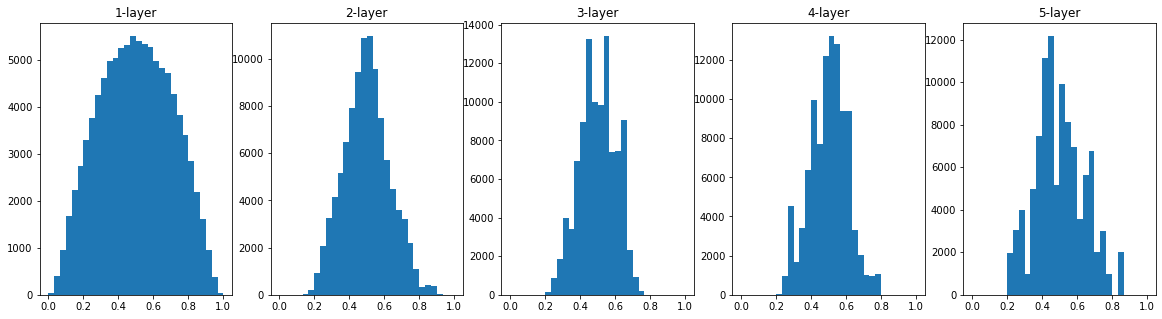

In [18]:
# Xavier 分布的权重初始化
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100
hiden_layer_size = 5
activations = {}

for i in range(hiden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)

    z = np.dot(x, w)
    a = sigmoid(z)
    activations[i] = a
plt.figure(figsize=(20,5))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i + 1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

权重初始值：

* sigmoid和tanh一般使用标准差为$\sqrt{\frac{1}{n}}$的高斯分布

* relu使用标准差为$\sqrt{\frac{2}{n}}$的高斯分布

## Batch normalization

Batch Norm的优点：

* 可以使学习快速进行

* 不那么依赖初始值

* 抑制过拟合

Batch Norm就是按照mini-batch进行正规化，使数据分布的均值为0、方差为1的正规化。

$$
\mu_B \leftarrow \frac{1}{m} \sum_{i=1}^{m} x_i \\
\sigma_{B}^2 \leftarrow \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu_B)^2 \\
\hat{x_i} \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \varepsilon }}
$$

正规化后会进行缩放和平移的变化：

$$
y_i \leftarrow \gamma \hat{x_i} + \beta
$$

$\gamma \text{和} \beta$初始化为0和1，然后通过学习调整到合适的值。

## 正则化

过拟合的原因：

* 模型拥有大量参数、表现力强

* 训练数据少

权值衰减是一种有效抑制过拟合的方法，该方法通过在学习过程中对大的权重进行惩罚，来抑制过拟合。很多过拟合都是由于权重参数取值过大才发生的。

一般会在损失函数里添加$\frac{1}{2}\lambda W^2$。

Dropout是另外一种抑制过拟合的方法，是在学习的过程中随机的删除神经元的方法。

In [1]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flag=True):
        if train_flag:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
    
    def backward(self, dout):
        return dout * self.mask

## 超参数的验证

一般训练数据用于学习，测试数据用于评估泛化能力，而超参数一般用验证集进行测试。

超参数的最优化，一般先确定其大致的范围，然后才再进一步进行调参。

步骤：

1. 设定超参数范围

2. 从设定的范围中随机采样

3. 使用2中的到的参数进行训练，通过验证集评估识别精度（一般这个时候epoch设置的比较小）

4. 重复步骤2、3，根据结果进行进一步的调整。